In [22]:
import numpy as np
import math
import random

In [23]:
np.e**2

7.3890560989306495

In [24]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [25]:
class Value:
    def __init__(self,data,_children=(),_op=[],label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda:None
    def __repr__(self):
        return f"Value(data={self.data})"
    def __add__(self,other):
        other = other if isinstance (other, Value) else Value (other)
        out = Value(self.data + other.data, (self,other),'+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    def __radd__(self,other):
        return self+other
    
    def __mul__(self,other):
        other = other if isinstance (other, Value) else Value (other)
        out = Value(self.data*other.data, (self,other),'*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    def __rmul__(self,other):
        return self*other
    def __sub__(self,other):
        return self+(-other)
    def __truediv__(self,other):
        return self * other**-1
    def __neg__(self): # -self
        return self * -1
    def __pow__(self, other):
        assert isinstance(other,(int,float)), "only supporting int/float"
        out = Value(self.data**other,(self,),f'**{other}')
        def _backward():
            self.grad += other * (self.data**(other-1)) * out.grad
        out._backward = _backward
        return out
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad+= out.data * out.grad
        out._backward = _backward
        return out

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t,(self, ),'tanh')
        def _backward():
            self.grad += (1 - (t**2)) * out.grad
        out._backward = _backward
        return out
    
                    
    def backprop(self):
        self.grad=1.0
        topo = []
        visited = set()
        def build_topo(root_node):
            if root_node not in visited:
                visited.add(root_node)
                for child in root_node._prev:
                    build_topo(child)
                topo.append(root_node)
            return topo
        build_topo(self)
        
        for node in reversed(topo):
            node._backward()


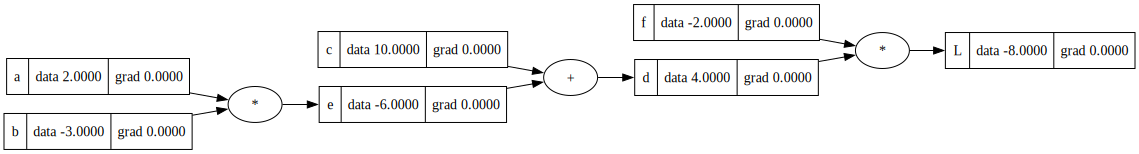

In [26]:
a = Value(2.0,label='a')
b = Value(-3.0,label='b')
c = Value(10.0,label='c')
e = a*b;e.label='e'
d = e+c;d.label = 'd'
f = Value(-2.0,label='f')
L = d*f;L.label='L'
draw_dot(L)

#### 1. Figure out backprop

In [27]:
# inputs x1,x2
x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x1')
# weights
w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')
# bias of neuron
b = Value(6.8813735870195432,label='b')

x1w1 = x1*w1;x1w1.label='x1*w1'
x2w2 = x2*w2;x2w2.label='x2*w2'
x1w1x2w2=x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'
n = x1w1x2w2 + b;n.label='n'
o = n.tanh();o.label='o'
o.backprop()

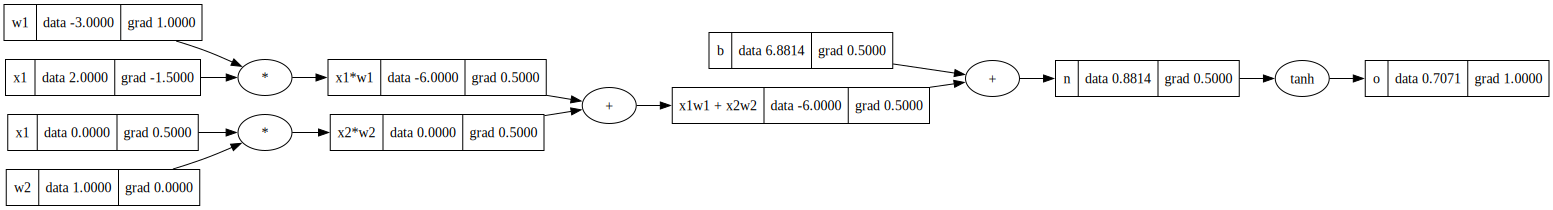

In [28]:
draw_dot(o)

In [29]:
# TODO: BACKPASS NOT WORKING FOR BELOW CELL

In [30]:
# inputs x1,x2
x1 = Value(2.0,label='x1')
x2 = Value(0.0,label='x2')
# weights
w1 = Value(-3.0,label='w1')
w2 = Value(1.0,label='w2')
# bias of neuron
b = Value(6.8813735870195432,label='b')

x1w1 = x1*w1;x1w1.label='x1*w1'
x2w2 = x2*w2;x2w2.label='x2*w2'
x1w1x2w2=x1w1 + x2w2; x1w1x2w2.label='x1w1 + x2w2'
n = x1w1x2w2 + b;n.label='n'
# ---
o = n.tanh()
# ---
# o = e^n - e^-n/e^n + e^-n
e = (2*n).exp()
# num = e - 1;num.label='num'
# den = e + 1;num.label='den'
o = (e-1) / (e+1)
o.label='o'
o.backprop()

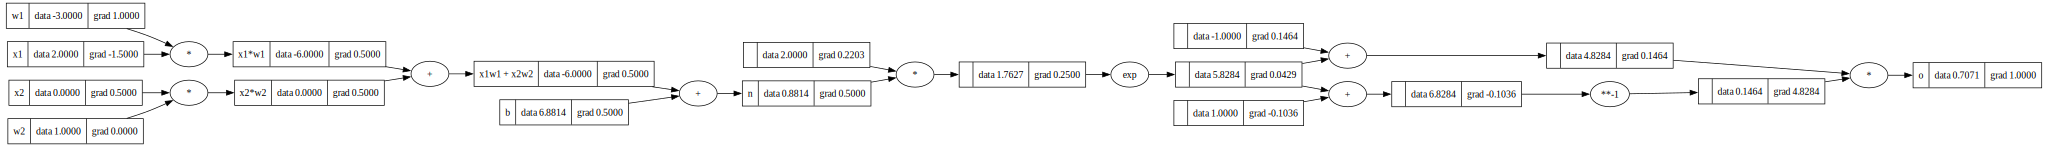

In [31]:
draw_dot(o)

In [32]:
o._backward()

In [33]:
n._backward()

In [34]:
b._backward()

In [35]:
x1w1x2w2._backward()

In [36]:
x1w1._backward()

In [37]:
x2w2._backward()

----
# Pytorch

In [38]:
import torch

In [39]:
x1 = torch.tensor([2.0]).double();x1.requires_grad=True
x2 = torch.tensor([0.0]).double();x2.requires_grad=True
w1 = torch.tensor([-3.0]).double();w1.requires_grad=True
w2 = torch.tensor([1.0]).double();w2.requires_grad=True
b = torch.tensor([6.8813735870195432]);b.requires_grad=True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)
print(o.data.item())
o.backward()
print('x2',x2.grad.item())
print('w2',w2.grad.item())
print('x1',x1.grad.item())
print('wl',w1.grad.item())

0.7071066904050358
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
wl 1.0000002567688737


---
# Making nn

In [49]:
class Neuron:
    def __init__(self,nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self,x):
        act = sum((wi*xi for wi,xi in zip(self.w,x)),self.b)
        out = act.tanh()
        return out

class Layer:
    def __init__(self,nin,nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)>1 else outs

        

neuron = Neuron(2)
x = [2.0,3.0]
neuron(x)

Value(data=0.9785558926041225)